
<div style="background-color:#CCCCCC; padding:12px; border-radius:8px;">
<h1 style="color:#003366; text-align:center; margin:8px 0;">Revisión y limpieza de 3 DataFrames (TPI - Data Analytics)</h1>
<p style="text-align:center; color:#003366; margin:0;"><em>Notebook docente en castellano — nombres descriptivos en snake_case — código y documentación</em></p>
</div>



<div style="background-color:#CCCCCC; padding:10px; border-radius:6px;">
<h2 style="color:black; text-align:center; margin-top:6px;">Resumen</h2>

<p style="color:black;">
Este notebook está diseñado con finalidades pedagógicas. Revisa, normaliza y valida tres datasets contenidos en CSV:
</p>

<ul style="color:black;">
<li><code>marketing.csv</code> → variable: <code>df_marketing</code></li>
<li><code>ventas.csv</code>    → variable: <code>df_ventas</code></li>
<li><code>clientes.csv</code>  → variable: <code>df_clientes</code></li>
</ul>

<p style="color:black;">
Coloca los CSV en <code>/content/drive/MyDrive/CABA/Garcia Traba Ariel H - Comisión 25262 - TPI Data Analytics/</code> 
    en <code>/datasets_entrada/</code>. El notebook busca primero en google drive y si no encuentra, usa <code>localhost (127.0.0.1)</code> (útil para entornos donde los archivos están pre-subidos).
</p>

</div>


In [74]:
# Imports y configuración inicial (nombres en castellano)
import os, re, json, unicodedata
from pathlib import Path
from datetime import datetime
from colorama import *
from math import isnan
import zipfile
from collections import defaultdict
import argparse
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
from typing import Dict, Any, Optional
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Crear un documento en Google Colaboratory y cargar los sets de datos como DataFrames

si se usa en disco local comentarla celda de debajo (JuPyteR , VSC, ATOM, Spider, Geany, etc)

# 1ra parte Definición de ETL
ETL es un conjunto de procedimientos que permiten mover datos desde sistemas de origen, que pueden ser bases de datos, archivos o fuentes en la nube, hasta un sistema de destino como un data warehouse o data lake, realizando previamente procesos de limpieza, estructuración y organización de los datos para hacerlos aptos para análisis.​

## Fases del proceso ETL
Extracción: Consiste en recopilar datos relevantes de diferentes fuentes, asegurando que el impacto en los sistemas origen sea mínimo. Los datos pueden extraerse mediante diversos métodos como consultas SQL o servicios web.​

Transformación: En esta etapa, los datos se limpian y se ajustan para garantizar coherencia y calidad, incluyendo la eliminación de valores nulos, normalización y conversión a formatos consistentes, además de aplicar reglas específicas de negocio.

Carga: Finalmente, los datos transformados se cargan en el sistema de destino, donde estarán disponibles para análisis, informes o modelado de datos.

## Importancia del ETL
Es crucial en la minería de datos porque preparar los datos brutos para que puedan ser utilizados en análisis estadísticos, modelados predictivos o técnicas de aprendizaje automático, asegurando la calidad, coherencia y accesibilidad de la información.

### 1.1 Crear estructura de directorios segun modelo

In [50]:
def carga_rutas():
    global carpeta_entrada,carpeta_datasets_entrada,carpeta_datasets_salida,carpeta_reportes,carpeta_limpios
    #archivo_ventas,archivo_clientes,archivo_marketing
    try: 
        carpeta_entrada    = Path(ruta_base)
        carpeta_datasets_entrada   = carpeta_entrada / 'datasets_entrada'
            
        carpeta_datasets_salida   = carpeta_entrada / 'datasets_salida'
        carpeta_datasets_salida.mkdir(parents=True, exist_ok=True)
        
        carpeta_reportes   = carpeta_datasets_salida / 'reportes'
        carpeta_reportes.mkdir(parents=True, exist_ok=True)
        
        carpeta_limpios    = carpeta_datasets_salida / 'limpios'
        carpeta_limpios.mkdir(parents=True, exist_ok=True)
    except Exception as e:
        print(f"""{Fore.WHITE+Back.RED}
        {e}""")
        exit()

### 1.2 rutas y carga de los dataframes

In [51]:
def carga_de_datos():
    global dic_dfs
    print("Cargando datasets del curso...")
    try:
        ruta_ventas     = os.path.join(carpeta_datasets_entrada, archivo_ventas)
        ruta_clientes   = os.path.join(carpeta_datasets_entrada, archivo_clientes)
        ruta_marketing  = os.path.join(carpeta_datasets_entrada, archivo_marketing)
        
        df_ventas       = pd.read_csv(f"{ruta_ventas}")
        df_clientes     = pd.read_csv(f"{ruta_clientes}")
        df_marketing    = pd.read_csv(f"{ruta_marketing}")
        dic_dfs = { "df_ventas"   : df_ventas,
                    "df_clientes" : df_clientes,
                    "df_marketing": df_marketing}
        print ("...Arhivos cargados con exito!!!")
    except FileNotFoundError:
        print("Archivos no encontrados en:", carpeta_datasets_entrada)
        exit()
    except pd.errors.EmptyDataError:
        print("Archivo vacío detectado")
        exit()

## desde python sin librerias pandas / polars

In [52]:
def carga_fuente_de_datos():
    global ruta_base, archivo_ventas, archivo_clientes,archivo_marketing
    archivo_ventas     = 'ventas.csv'
    archivo_clientes   = 'clientes.csv'
    archivo_marketing  = 'marketing.csv'
    #################################################################################
    try: 
        print(f"""{Fore.WHITE+Back.BLUE}
╔═════════════════════════════════════════════════════════════════════════════╗
║                      Datos en ámbito Google Drive                           ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
        # Montar tu Google Drive
        !pip install google
        from google.colab import drive
        drive.mount('/content/drive')
        !ls "/content/drive/MyDrive/CABA/Garcia Traba Ariel H - Comisión 25262 - TPI Data Analytics/"
        # Ruta del archivo (ajústala a la carpeta real en tu Drive)
        ruta_base = "/content/drive/MyDrive/CABA/Garcia Traba Ariel H - Comisión 25262 - TPI Data Analytics/"
        carga_rutas()
        if not os.path.exists(ruta_base):
            raise FileNotFoundError(f"La carpeta especificada no existe: {ruta_base}")
        carga_de_datos()
        print(f"""{Fore.WHITE+Back.BLUE}
╔═════════════════════════════════════════════════════════════════════════════╗
║                      Google Drive cargado con exito                         ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
        return
    except Exception as e:
        print(f"""{Fore.WHITE+Back.RED}
        {e}
╔═════════════════════════════════════════════════════════════════════════════╗
║                          Google Drive NO cargado                            ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
    #################################################################################
    try:
        print(f"""{Fore.WHITE+Back.BLUE}
╔═════════════════════════════════════════════════════════════════════════════╗
║                          Datos en ámbito local                              ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
        ruta_base = "./"
        print (f"{ruta_base=}")
        carga_rutas()
        print (f"{carpeta_entrada=}")
        print ("*"*50)
        if not os.path.exists(ruta_base):
            raise FileNotFoundError(f"La carpeta especificada no existe: {ruta_base}")
        carga_de_datos()
        print(f"""{Fore.WHITE+Back.GREEN}
╔═════════════════════════════════════════════════════════════════════════════╗
║                        ámbito local cargado con exito                       ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
        return
    except Exception as e:
        print(f"""{Fore.WHITE+Back.RED}
        {e}
╔═════════════════════════════════════════════════════════════════════════════╗
║                         ámbito local  NO cargado                            ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
    #################################################################################
    '''
    try:
        print(f"""{Fore.WHITE+Back.BLUE}
╔═════════════════════════════════════════════════════════════════════════════╗
║                          Datos en ámbito github                             ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
        ruta_base = "https://github.com/CursosAGT/-GarciaTrabaArielH-Comisi-n25262-TPI_Data_Analytics/tree/main/datasets_salida/limpios"
        carga_rutas()
        if not os.path.exists(ruta_base):
            raise FileNotFoundError(f"La carpeta especificada no existe: {ruta_base}")
        carga_de_datos()  
        print(f"""{Fore.WHITE+Back.GREEN}
╔═════════════════════════════════════════════════════════════════════════════╗
║                        ámbito github cargado con exito                      ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
        return
    except Exception as e:
        print(f"""{Fore.WHITE+Back.RED}
        {e}
╔═════════════════════════════════════════════════════════════════════════════╗
║                         ámbito github NO cargado                            ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
    '''
    #################################################################################
    print(f"""{Fore.WHITE+Back.RED}
╔═════════════════════════════════════════════════════════════════════════════╗
║                  No se encontraron los datos básicos (CSV)                  ║
║                  No se puede continuar                                      ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
    exit()
carga_fuente_de_datos()


╔═════════════════════════════════════════════════════════════════════════════╗
║                      Datos en ámbito Google Drive                           ║
╚═════════════════════════════════════════════════════════════════════════════╝

        No module named 'google'
╔═════════════════════════════════════════════════════════════════════════════╗
║                          Google Drive NO cargado                            ║
╚═════════════════════════════════════════════════════════════════════════════╝

╔═════════════════════════════════════════════════════════════════════════════╗
║                          Datos en ámbito local                              ║
╚═════════════════════════════════════════════════════════════════════════════╝
ruta_base='./'
carpeta_entrada=WindowsPath('.')
**************************************************
Cargando datasets del curso...
...Arhivos cargados con exito!!!

╔═════════════════════════════════════════════════════════════════════════════╗


### 1.3 Estructura de parámetros 

In [53]:
# ---------- Proceso principal para los 3 CSV ----------
desviacion_margen     = 1.5
desviacion_umbral     = 3.0
cantidad_duplicados   = 0
reportes_creados      = []
ruta_excel            = carpeta_reportes / 'reporte_limpieza.xlsx'
guardado_ok           = False
mensajes              = []
TOKENS_VALOR_FALTANTE = {'na', 'n/a', 'null', 'none', 'sin dato', 's/d', 'nd', '-', '--', '?', 'sin_dato', 'n/d'}


reglas= {
            "df_marketing" : {
                                'producto':     {'string' : {'tipo': 'lower', 'normalizar_acentos': True}},
                                'canal':        {'string' : {'tipo': 'upper', 'normalizar_acentos': True}},
                                'costo':        {'numeric': {'as_int': False}},
                                'fecha_inicio': {'date'   : {'dayfirst': True, 'formats': ['%d/%m/%Y', '%Y-%m-%d']}},
                                'fecha_fin':    {'date'   : {'dayfirst': True, 'formats': ['%d/%m/%Y', '%Y-%m-%d']}}
                                },
            # id_venta, producto, precio, cantidad, fecha_venta, categoria
            "df_ventas" : {
                                'producto':     {'string' : {'tipo': 'lower', 'normalizar_acentos': True}},
                                'precio':       {'numeric': {'as_int': False}},
                                'cantidad':     {'numeric': {'as_int': False}},
                                'fecha_venta':  {'date'   : {'dayfirst': True, 'formats': ['%d/%m/%Y', '%Y-%m-%d']}},
                                'categoria':    {'string' : {'tipo': 'lower', 'normalizar_acentos': True}}
                            },
            # id_cliente, nombre, edad, ciudad, ingresos
            "df_clientes" : {
                                'nombre':       {'string'  : {'tipo': 'title', 'normalizar_acentos': True}},
                                'edad':         {'numeric' : {'as_int': True}},
                                'ciudad':       {'string'  : {'tipo': 'title', 'normalizar_acentos': True}},
                                'ingresos':     {'numeric' : {'as_int': False}}
                            }
    }
reglas_por_archivo = {
    'ventas.csv':    reglas["df_ventas"],
    'clientes.csv':  reglas["df_clientes"],
    'marketing.csv': reglas["df_marketing"]
}

#zip_path = carpeta_reportes.parent / 'reports_dataset_tpi_v2.zip'


In [54]:
# Mostrar el DataFrame
def ver(df :pd.DataFrame,nombre_df =""):
    print(f"""{Fore.WHITE+Back.BLUE}
╔═════════════════════════════════════════════════════════════════════════════╗
║                            E.T.L.:  {nombre_df.center(20)}                    ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}
        Descripción preliminar:
        {df.describe()}
        Dimensiones:      { df.ndim}
        Forma:            { df.shape}
                filas:    {df.shape[0]}
                Número de elementos:{ df.size}
                Nombres de filas:{ df.index}
                columnas: {df.shape[1]}
                Nombres de columnas:{ df.columns}
        Valores nulos:    {df.isna().sum().to_dict()}
        Valores duplicados:{int(df.duplicated(keep=False).sum())}
        Tipos de datos:\n{ df.dtypes}
        Primeras 7 filas:\n{ df.head(7)}
        Últimas 3 filas:\n{ df.tail(3)}
    {"*"*50}
    """)

In [55]:
def es_valor_faltante(serie,nombre_serie,nombre_df):
    """
    Determina si los valores de una serie deben considerarse faltantes.
    
    Parámetros:
        serie (pd.Series): columna de pandas a evaluar.
    
    Retorna:
        dict:
            'mask' -> pd.Series booleana (True si el valor es faltante)
            'valores_faltantes' -> lista de valores detectados como faltantes
    """
    serie_limpia = serie.astype(str).str.strip().str.lower()
    mask = serie.isna() | serie_limpia.isin(TOKENS_VALOR_FALTANTE)
    
    # Extraemos los valores faltantes con su índice
    valores_detectados = serie[mask]
    
    if not valores_detectados.empty:
        print(f"""{Fore.WHITE+Back.RED}
╔═════════════════════════════════════════════════════════════════════════════╗
║                             Valor NO VALIDO                                 ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}
{nombre_df=}      {nombre_serie=}
Valores faltantes detectados con fila/índice:\n, {valores_detectados}""")
    return {'mask': mask, 'valores_faltantes': valores_detectados.unique().tolist()}#True si es NaN o está en los tokens de faltante

In [56]:
def series_en_dataframes(nombre_df, df_cada):
    for nombre_serie, serie in df_cada.items():
        resultado = es_valor_faltante(serie,nombre_serie,nombre_df)           
        nombre_serie= nombre_serie.lower().replace(" ","_")
        if nombre_serie.startswith("id_"):
            continue
        regla =  next(iter(reglas[nombre_df][nombre_serie]))
        '''
        print (f"""
        {nombre_serie=}
        {serie=}
        {regla=}
        """)'''
        s = serie.copy()
        if regla == "numeric":
            try:
                s = s.astype(str).str.strip()
                '''
            ╔═════════════════════════════════════════════════════════════════════════════╗
            ║                              Sacar simbolo $                                ║
            ╚═════════════════════════════════════════════════════════════════════════════╝'''
                s = s.str.replace('$', '')
            except:
                pass
            '''
            ╔═════════════════════════════════════════════════════════════════════════════╗
            ║                              A numerico (float 32/4)                        ║
            ╚═════════════════════════════════════════════════════════════════════════════╝'''
            # difiere para windows vs mac-linuxs = pd.to_numeric(s, errors="coerce").astype(np.float32)
            s = pd.to_numeric(s, errors="coerce", downcast='float')  # Intenta float32
            if reglas[nombre_df][nombre_serie]["numeric"]["as_int"] :
                s = s.replace('.', '').replace(',', '')
                if not s.isna().any():
                    '''
            ╔═════════════════════════════════════════════════════════════════════════════╗
            ║                              A numerico (int32/4)                           ║
            ╚═════════════════════════════════════════════════════════════════════════════╝'''
                    s = s.astype(np.int32)  # Garantizado int32
        elif regla == "string":
            '''
            ╔═════════════════════════════════════════════════════════════════════════════╗
            ║      Verdadero formato Python papa reemplazar mas de 2 espacios por 1       ║
            ╚═════════════════════════════════════════════════════════════════════════════╝'''
            s = s.astype(str).str.strip().replace(r'\s+', ' ', regex=True)
            match  reglas[nombre_df][nombre_serie][regla]["tipo"] :
                case "upper":
                    s = s.str.upper()
                case "title":
                    s = s.str.title()
                case "lower":
                    s = s.str.lower()
            '''
            ╔═════════════════════════════════════════════════════════════════════════════╗
            ║                              Sacar acentos                                  ║
            ╚═════════════════════════════════════════════════════════════════════════════╝'''
            #texto_n = unicodedata.normalize("NFD", entrada)
            s= s.apply(  lambda x: ''.join( c for c in unicodedata.normalize('NFKD', str(x)) if not unicodedata.combining(c)  )  )
            #''.join(c for c in unicodedata.normalize('NFKD', str(x))  if not unicodedata.combining(c))  for x in df["columna"]
            '''            
            Modo	Significado	Qué hace	Cuándo usar
            NFD	Normalization Form Decomposition	Descompone los caracteres Unicode en su forma básica y diacrítica. Ej: "á" → "a" + " ́"	Cuando solo querés separar acentos.
            NFKD	Compatibility Decomposition	Hace lo mismo más normaliza formas equivalentes "compatibles" (por ejemplo, “①” → “1”, “ﬂ” → “fl”)	Ideal para limpieza más completa de texto.
            '''
        elif regla == "date":
            '''
            ╔═════════════════════════════════════════════════════════════════════════════╗
            ║                   Formato de fecha ISO('%Y/%m/%d') YYYY/MM/DD               ║
            ╚═════════════════════════════════════════════════════════════════════════════╝'''
            s = pd.to_datetime(  s,  dayfirst=reglas[nombre_df][nombre_serie][regla]["dayfirst"],   errors="coerce"  ) 
            #s = s.dt.strftime('%Y/%m/%d')
        #elif regla == "fillna":
            #s = s.fillna(0)
        dic_dfs[nombre_df][nombre_serie] = s
        '''
        print (f"""
        {"*"*50}
        {regla=}""")'''
         
    return dic_dfs[nombre_df]

In [57]:
def dataframes_en_diccionario():
    """
    Limpia el DataFrame aplicando reglas_por_columna = {"col": ("regla", parametros)...}
    Las reglas se asignan automáticamente según el tipo o formato:
      - Columnas numéricas o con símbolos ($, %, dígitos) → 'numeric'
      - Columnas que parecen fechas → 'date'
      - Otras columnas → 'string'
    """
    for nombre_df, df_cada in dic_dfs.items():           
        dic_dfs[nombre_df] = series_en_dataframes(nombre_df, df_cada)
        #print (dic_dfs[nombre_df].head(40))
        ver( dic_dfs[nombre_df],nombre_df)
dataframes_en_diccionario()


╔═════════════════════════════════════════════════════════════════════════════╗
║                             Valor NO VALIDO                                 ║
╚═════════════════════════════════════════════════════════════════════════════╝
nombre_df='df_ventas'      nombre_serie='precio'
Valores faltantes detectados con fila/índice:
, 136    NaN
139    NaN
Name: precio, dtype: object

╔═════════════════════════════════════════════════════════════════════════════╗
║                             Valor NO VALIDO                                 ║
╚═════════════════════════════════════════════════════════════════════════════╝
nombre_df='df_ventas'      nombre_serie='cantidad'
Valores faltantes detectados con fila/índice:
, 136   NaN
139   NaN
Name: cantidad, dtype: float64

╔═════════════════════════════════════════════════════════════════════════════╗
║                            E.T.L.:       df_ventas                          ║
╚═══════════════════════════════════════════════════════════

<div style="background-color:#7FFFD4; padding:10px; border-radius:6px;">
    <h2 style="color:black; text-align:center; margin-top:6px;">Decisión</h2>
    <p style="color:black;">
    Resolución del analista de datos
    </p>
    <p style="color:black;">Se encontraron 2 registros NaN</p>
        <ul style="color:black;">
            <li>Cada registro tiene dos valores faltantes (cantidad y precio)</li>
            <li>Los precios se pueden evaluar buscando el mismo producto con fecha similar (inflación)</li>
            <li>Las cantidades no se pueden inventar, aunque si el DF fuese más grande y el cliente tuviese varias compras se evaluaría un promedio de las anteriores</li>
        </ul>
    <p style="color:#0000ff;">En base a esto se procede a borrar los registros con datos nulos o faltantes</p>
</div>
<!-- si amo la tabulacion/identación -->

In [58]:
def eliminar_registros():
    global n_registros_eliminados, df_registros_eliminados
    
    print(f"Antes:  {dic_dfs['df_ventas'].shape}")
    
    # Guardar cantidad inicial
    n_inicial = len(dic_dfs['df_ventas'])
    
    # Identificar registros con NaN en 'cantidad'
    mascara_nulos = dic_dfs['df_ventas']['cantidad'].isna()
    registros_a_eliminar = dic_dfs['df_ventas'][mascara_nulos].copy()
    
    # Agregar información sobre el motivo de eliminación
    if not registros_a_eliminar.empty:
        registros_a_eliminar['motivo_eliminacion'] = 'NaN en cantidad'
        registros_a_eliminar['dataframe_origen'] = 'df_ventas'
        registros_a_eliminar['columna_problema'] = 'cantidad'
        
        # Acumular en el DataFrame global
        if 'df_registros_eliminados' not in globals() or df_registros_eliminados is None:
            df_registros_eliminados = registros_a_eliminar
        else:
            df_registros_eliminados = pd.concat([df_registros_eliminados, registros_a_eliminar], ignore_index=True)
    
    # Eliminar registros con NaN en 'cantidad'
    dic_dfs['df_ventas'] = dic_dfs['df_ventas'].dropna(subset=['cantidad'])
    
    # Calcular registros eliminados
    n_final = len(dic_dfs['df_ventas'])
    n_registros_eliminados = n_inicial - n_final
    
    print(f"Después: {dic_dfs['df_ventas'].shape}")
    print(f"""
    Se eliminaron '{n_registros_eliminados}' registros donde la cantidad estaba en null o NaN
    """)
    
    return n_registros_eliminados

# Inicializar el DataFrame global
df_registros_eliminados = None

# Ejecutar
eliminar_registros()

# Ver los registros eliminados
if df_registros_eliminados is not None:
    print("\n" + "="*80)
    print("REGISTROS ELIMINADOS ACUMULADOS:")
    print("="*80)
    print(df_registros_eliminados)
    print(f"\nTotal de registros eliminados: {len(df_registros_eliminados)}")

Antes:  (3035, 6)
Después: (3033, 6)

    Se eliminaron '2' registros donde la cantidad estaba en null o NaN
    

REGISTROS ELIMINADOS ACUMULADOS:
     id_venta               producto  precio  cantidad fecha_venta  \
136       627  elementos de ceramica     NaN       NaN  2024-01-17   
139      2171    parlantes bluetooth     NaN       NaN  2024-01-17   

       categoria motivo_eliminacion dataframe_origen columna_problema  
136   decoracion    NaN en cantidad        df_ventas         cantidad  
139  electronica    NaN en cantidad        df_ventas         cantidad  

Total de registros eliminados: 2


In [59]:
def buscar_y_eliminar_duplicados_exactos(nombre_df, df: pd.DataFrame, keep='first', inplace=False) -> pd.DataFrame:
    """
    Elimina duplicados exactos.
    
    Parámetros:
    -----------
    nombre_df : str
        Nombre del DataFrame
    df : DataFrame
        DataFrame a procesar
    keep : str, default 'first'
        - 'first': mantiene la primera ocurrencia
        - 'last': mantiene la última ocurrencia
        - False: elimina todas las ocurrencias
    inplace : bool, default False
        Si True, modifica el DataFrame original
    
    Retorna:
    --------
    DataFrame sin duplicados (o None si inplace=True)
    """
    global df_duplicados_total
    global n_duplicados
    # Obtener máscara de duplicados
    mascara_duplicados = df.duplicated(keep=False)#(keep=keep)
    n_duplicados = mascara_duplicados.sum()
    
    # Guardar duplicados encontrados
    if n_duplicados > 0:
        duplicados = df[df.duplicated(keep=False)]  # Todos los duplicados (incluyendo primera ocurrencia)
        
        # Inicializar o concatenar al DataFrame global
        if 'df_duplicados_total' not in globals() or df_duplicados_total is None:
            df_duplicados_total = duplicados.copy()
            df_duplicados_total['origen_df'] = nombre_df
        else:
            duplicados_temp = duplicados.copy()
            duplicados_temp['origen_df'] = nombre_df
            df_duplicados_total = pd.concat([df_duplicados_total, duplicados_temp], ignore_index=True)
        print(f"""{Fore.BLACK+Back.YELLOW}{f"[{nombre_df}] Se encontraron {n_duplicados} duplicados exactos".center(50)}{Style.RESET_ALL}""")
        # Eliminar duplicados
        if inplace:
            df.drop_duplicates(keep=keep, inplace=True)
            dic_dfs[nombre_df] = df
            return None
        else:
            df_limpio = df.drop_duplicates(keep=keep)
            dic_dfs[nombre_df] = df_limpio
            return df_limpio
    else:
        print(f"""{Fore.BLACK+Back.BLUE}{f"[{nombre_df}] No hay duplicados".center(50)}{Style.RESET_ALL}""")
        if inplace:
            return None
        else:
            return df

df_duplicados_total = None

# Procesar todos los DataFrames
for nombre_df, df_cada in dic_dfs.items():           
    buscar_y_eliminar_duplicados_exactos(nombre_df, df_cada)
print (f"""
{df_duplicados_total}
""")

 [df_ventas] Se encontraron 70 duplicados exactos 
         [df_clientes] No hay duplicados          
         [df_marketing] No hay duplicados         

     id_venta            producto      precio  cantidad fecha_venta  \
820        56            cortinas   66.239998       5.0  2024-04-05   
821       421     lampara de mesa  114.830002       9.0  2024-04-05   
822       424   jarron decorativo   87.940002       2.0  2024-04-05   
823      1868            cafetera   62.230000       1.0  2024-04-05   
824      2545         auriculares   32.810001      11.0  2024-04-05   
..        ...                 ...         ...       ...         ...   
885      1381  freidora electrica   38.119999       2.0  2024-04-08   
886      2365         auriculares   92.910004      11.0  2024-04-08   
887      2486              laptop  124.949997      11.0  2024-04-08   
888      2506              laptop   34.740002       1.0  2024-04-08   
889      2705         auriculares   87.290001       2.0  2024-04-

In [60]:
def buscar_valores_atipicos_zscore(serie):
    """
    Devuelve máscara booleana (True = outlier) según Z-score.
    """
    serie_limpia = serie.dropna().astype(float)
    if serie_limpia.shape[0] < 4 or serie_limpia.std() == 0:
        return pd.Series([False] * len(serie), index=serie.index)
    puntaje_z = (serie - serie_limpia.mean()) / serie_limpia.std()
    return puntaje_z.abs() > desviacion_umbral  
print('Funciones utilitarias definidas.')

Funciones utilitarias definidas.


In [61]:
def buscar_valores_atipicos_rango_intercuartil(serie):# Detección de outliers (IQR) - función corregida y robusta
    """
    Devuelve una tupla: (mascara_bool_series, cantidad_outliers, (limite_inferior, limite_superior))
    """
    serie = pd.to_numeric(serie, errors='coerce')
    serie_limpia = serie.dropna().astype(float)
    
    if serie_limpia.shape[0] < 4:
        mascara = pd.Series([False] * len(serie), index=serie.index)
        return mascara, int(mascara.sum()), (None, None)
    
    cuartil_1 = float(serie_limpia.quantile(0.25))
    cuartil_3 = float(serie_limpia.quantile(0.75))
    rango_intercuartil = cuartil_3 - cuartil_1
    limite_inferior = cuartil_1 - desviacion_margen * rango_intercuartil
    limite_superior = cuartil_3 + desviacion_margen * rango_intercuartil
    
    mascara = (serie < limite_inferior) | (serie > limite_superior)
    mascara = mascara.fillna(False).astype(bool)
    
    return mascara, int(mascara.sum()), (limite_inferior, limite_superior)

## Guardar valores

In [62]:
def guardar_csv(df, ruta):# Función auxiliar para guardar CSVs
    """
    Guarda df en ruta (string o Path). Crea directorio padre si no existe.
    """
    ruta = Path(ruta)
    ruta.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(ruta, index=False, encoding='utf-8')
    return ruta

In [63]:
for [path_archivo, df_actual],[nombre_archivo,_] in zip( dic_dfs.items() , reglas_por_archivo.items() ):

    nombre_limpio = nombre_archivo[:-4] + '_limpio.csv' if nombre_archivo.lower().endswith('.csv') else nombre_archivo + ' limpio.csv'
    print(f'nombre_limpio = {nombre_limpio}')
    # guardar cleaned
    ruta_guardado = carpeta_limpios / nombre_limpio
    guardar_csv(df_actual, ruta_guardado)
    print(f'Guardado cleaned en: {ruta_guardado}')

nombre_limpio = ventas_limpio.csv
Guardado cleaned en: datasets_salida\limpios\ventas_limpio.csv
nombre_limpio = clientes_limpio.csv
Guardado cleaned en: datasets_salida\limpios\clientes_limpio.csv
nombre_limpio = marketing_limpio.csv
Guardado cleaned en: datasets_salida\limpios\marketing_limpio.csv


In [64]:
def guardar_excel():
    """
    Guarda los DataFrames de análisis en un archivo Excel con múltiples hojas.
    
    Hojas:
    - outliers: Valores atípicos detectados
    - duplicados: Registros duplicados encontrados
    - eliminados: Registros eliminados por NaN u otros motivos
    """
    global df_outliers, df_duplicados_total, df_registros_eliminados
    mensajes = []
    guardado_ok = False
        
    try:
        with pd.ExcelWriter(ruta_excel, engine='openpyxl') as writer:
            
            # Hoja 1: Outliers
            try:
                if 'df_outliers' in globals() and df_outliers is not None and not df_outliers.empty:
                    df_outliers.to_excel(writer, index=False, sheet_name='outliers')
                    mensajes.append(f'Hoja "outliers": {len(df_outliers)} registros')
                else:
                    pd.DataFrame({'mensaje': ['No se detectaron outliers']}).to_excel(writer, index=False, sheet_name='outliers')
                    mensajes.append('Hoja "outliers": vacía')
            except Exception as e:
                pd.DataFrame({'error': [str(e)]}).to_excel(writer, index=False, sheet_name='outliers')
                mensajes.append(f'Error en hoja "outliers": {str(e)}')
            
            # Hoja 2: Duplicados
            try:
                if 'df_duplicados_total' in globals() and df_duplicados_total is not None and not df_duplicados_total.empty:
                    df_duplicados_total.to_excel(writer, index=False, sheet_name='duplicados')
                    mensajes.append(f'Hoja "duplicados": {len(df_duplicados_total)} registros')
                else:
                    pd.DataFrame({'mensaje': ['No se encontraron duplicados']}).to_excel(writer, index=False, sheet_name='duplicados')
                    mensajes.append('Hoja "duplicados": vacía')
            except Exception as e:
                pd.DataFrame({'error': [str(e)]}).to_excel(writer, index=False, sheet_name='duplicados')
                mensajes.append(f'Error en hoja "duplicados": {str(e)}')
            
            # Hoja 3: Registros eliminados
            try:
                if 'df_registros_eliminados' in globals() and df_registros_eliminados is not None and not df_registros_eliminados.empty:
                    df_registros_eliminados.to_excel(writer, index=False, sheet_name='eliminados')
                    mensajes.append(f'Hoja "eliminados": {len(df_registros_eliminados)} registros')
                else:
                    pd.DataFrame({'mensaje': ['No se eliminaron registros']}).to_excel(writer, index=False, sheet_name='eliminados')
                    mensajes.append('Hoja "eliminados": vacía')
            except Exception as e:
                pd.DataFrame({'error': [str(e)]}).to_excel(writer, index=False, sheet_name='eliminados')
                mensajes.append(f'Error en hoja "eliminados": {str(e)}')
        
        guardado_ok = True
        
    except Exception as e_openpyxl:
        mensajes.append(f'Error usando openpyxl: {str(e_openpyxl)}')
        guardado_ok = False
    print(f"""{Fore.WHITE+Back.BLUE}\n
╔═════════════════════════════════════════════════════════════════════════════╗
║                              REPORTE EXCEL GUARDADO                         ║
║                     Ruta:    {str(ruta_excel).center(40)} ║
║                     Estado:  {str(guardado_ok).center(20)}                           ║
║                              {"EXITOSO".center(20) if guardado_ok else "FALLIDO".center(20)}                           ║
║    Detalle por hoja:                                                        ║
╠═════════════════════════════════════════════════════════════════════════════╣
║                     Aplico reglas según columna específica                  ║""")
    for m in mensajes:
        print (f"""║                     Estado:  {m.ljust(40)}       ║""")
    print (f"""╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
   
    return guardado_ok

# limpieza y normalización

In [65]:
def menu_procesar_diccionario():
    """
    Recorre dic_frames y detecta outliers, guardándolos en un DataFrame
    """
    print(f"""{Fore.WHITE+Back.BLUE}\n
╔═════════════════════════════════════════════════════════════════════════════╗
║                              Valores Modificado                             ║
╠═════════════════════════════════════════════════════════════════════════════╣
║     Afecta                                                                  ║
║         Elimina espacios iniciales y finales.                               ║
║         Borra Na                                                            ║
║         Borra duplicados                                                    ║
╠═════════════════════════════════════════════════════════════════════════════╣
║                     Aplico reglas según columna específica                  ║
╠═════════════════════════════════════════════════════════════════════════════╣
║     Afecta                                                                  ║
║             Numéricos (int/float)                                           ║
║             fechas --> YYYY,MM,DD                                           ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
    outliers_totales = [] 
    for [path_archivo, df_actual], [nombre_archivo, _] in zip(dic_dfs.items(), reglas_por_archivo.items()):
        print(f"""{Fore.WHITE+Back.BLUE}\n
╔═════════════════════════════════════════════════════════════════════════════╗
║                              {nombre_archivo.center(20)}                           ║
╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")
        for columna in df_actual.columns:
            serie = df_actual[columna]
            
            # Verificar si es numérica
            if serie.dtype.kind not in ['i', 'f']:
                continue

            if len(serie) < 4:
                continue
            mascara_zscore = buscar_valores_atipicos_zscore(serie)
            
            # Detección por IQR
            mascara_iqr, cant_iqr, (lim_inf, lim_sup) = buscar_valores_atipicos_rango_intercuartil(serie)
            lim_inf=round(lim_inf,2)
            lim_sup=round(lim_sup,2)
            # Combinar métodos: outlier detectado por al menos un método
            mascara_combinada = mascara_zscore | mascara_iqr
            
            # Si hay outliers, guardarlos
            if mascara_combinada.sum() > 0:
                # Obtener índices de outliers
                indices_outliers = serie[mascara_combinada].index
                
                for idx in indices_outliers:
                    valor = serie.loc[idx]
                    
                    # Determinar qué métodos lo detectaron
                    metodos = []
                    if mascara_zscore.loc[idx]:
                        metodos.append('Z-score')
                    if mascara_iqr.loc[idx]:
                        metodos.append('IQR')
                    
                    # Calcular Z-score del valor
                    if serie.std() != 0:
                        z_valor = (valor - serie.mean()) / serie.std()
                    else:
                        z_valor = None
                    
                    outliers_totales.append({
                        'dataframe': nombre_archivo,
                        'columna': columna,
                        'indice': idx,
                        'valor': valor,
                        'metodo_deteccion': ', '.join(metodos),
                        'z_score': z_valor,
                        'limite_inf_iqr': lim_inf,
                        'limite_sup_iqr': lim_sup,
                        'media_serie': serie.mean(),
                        'std_serie': serie.std()
                    })
            
            # Imprimir resumen
            print(f"""
╔═══════════════════════════════════════════════════════════════════════════╗
║ DataFrame: {nombre_archivo.center(60)}   ║
║ Columna: {columna.center(64)} ║
╠═══════════════════════════════════════════════════════════════════════════╣
║ Outliers por Z-score:  {str(mascara_zscore.sum()).center(50)} ║
║ Outliers por IQR:      {str(cant_iqr).center(50)} ║
║ Total combinado:       {str(mascara_combinada.sum()).center(50)} ║
║ Límites IQR:           [{str(lim_inf).center(10)}, {str(lim_sup).center(10)}]                           ║
╚═══════════════════════════════════════════════════════════════════════════╝
""")
        
        # Crear DataFrame con todos los outliers
        df_outliers = pd.DataFrame(outliers_totales)
        
        print(f"\n{'='*80}")
        print(f"RESUMEN TOTAL DE OUTLIERS DETECTADOS: {len(df_outliers)}")
        print(f"{'='*80}\n")
        
        if not df_outliers.empty:
            print(df_outliers.head(5))
            ruta_outliers = carpeta_reportes / 'outliers_detectados.csv'
            guardar_csv(df_outliers, ruta_outliers)
            print(f"\n Outliers guardados en: {ruta_outliers}")
    return df_outliers
print ("*"*50)
df_outliers = menu_procesar_diccionario()
guardar_excel()

**************************************************


╔═════════════════════════════════════════════════════════════════════════════╗
║                              Valores Modificado                             ║
╠═════════════════════════════════════════════════════════════════════════════╣
║     Afecta                                                                  ║
║         Elimina espacios iniciales y finales.                               ║
║         Borra Na                                                            ║
║         Borra duplicados                                                    ║
╠═════════════════════════════════════════════════════════════════════════════╣
║                     Aplico reglas según columna específica                  ║
╠═════════════════════════════════════════════════════════════════════════════╣
║     Afecta                                                                  ║
║             Numéricos (int/float)                                

True

<div style="background-color:#CCCCCC; padding:10px; border-radius:6px;">
    <h1 style="color:black; text-align:center;">Limpieza de Datos</h1>
    <h2 style="color:black; text-align:center;">Resultados</h2>
    <p style="color:black;">- Revisados los 3 csv  pasados a DataFrames.</p>
    <p style="color:blue;">- DataFrames filtrados.</p>
        <ul>
            <li style="color:black;">- Filtrado de Nulos.</li>
            <li style="color:black;">- Filtrado de duplicados.</li>
            <li style="color:black;">- Sin '', 'na', 'n/a', 'null', 'none', 'sin dato', 's/d', 'nd', '-', '--', '?', 'sin_dato', 'n/d'</li>    
            <li style="color:black;">- Normalisados Strings segun reglas. Estilo (lower,string.upper) unicodedata.normalize('NFKD')</li>
            <li style="color:black;">- Normalisados Strings segun reglas. sin acentos</li>
            <li style="color:black;">- Normalisados precios a float sin signo ($)</li>
            <li style="color:black;">- Normalisados Numericos a int o float segun regla</li>    
            <li style="color:black;">- Normalisados Fechas segun regla YYYY/MM/DD</li>    
        </ul>
    <p style="color:black;">- Resguardo <code>datasets_salida/limpios/clientes_limpio.csv</code>.</p>
    <p style="color:black;">- Resguardo <code>datasets_salida/limpios/marketing_limpio.csv</code>.</p>
    <p style="color:black;">- Resguardo <code>datasets_salida/limpios/ventas_limpio.csv</code>.</p>
    <p style="color:blue;">- Registros filtrados eliminados</p>
    <p style="color:black;">- Resguardo <code>datasets_salida/reportes/reporte_limpieza.xlsx</code> con hojas (duplicados con igual id borrados, outliers, valores faltantes)</p>
</div><!-- dios salve lña tabulacion :)-->

ventas.csv  análisis de ventas, limpieza de datos y estadísticas descriptivas.
 	
clientes.csv  unirse a las ventas mediante el uso de funciones de combinación para analizar características de los clientes relacionados con sus 	compras.
 	
marketing.csv analizar la efectividad de las campañas de marketing en las ventas y buscar correlaciones.


In [66]:
dic_dfs["df_ventas"]['precio_total'] = dic_dfs["df_ventas"]['precio'] * dic_dfs["df_ventas"]['cantidad']
print (f"""
{dic_dfs["df_ventas"].columns}
{dic_dfs["df_ventas"].head(5)}
""")


Index(['id_venta', 'producto', 'precio', 'cantidad', 'fecha_venta',
       'categoria', 'precio_total'],
      dtype='object')
   id_venta           producto      precio  cantidad fecha_venta  \
0       792  cuadro decorativo   69.940002       5.0  2024-01-02   
1       811    lampara de mesa  105.099998       5.0  2024-01-02   
2      1156           secadora   97.959999       3.0  2024-01-02   
3      1372           heladera  114.349998       8.0  2024-01-02   
4      1546           secadora  106.209999       4.0  2024-01-02   

           categoria  precio_total  
0         decoracion    349.700012  
1         decoracion    525.500000  
2  electrodomesticos    293.880005  
3  electrodomesticos    914.799988  
4  electrodomesticos    424.839996  



In [67]:
print (f"""
{dic_dfs["df_ventas"].columns}
{dic_dfs["df_marketing"].columns}
""")


Index(['id_venta', 'producto', 'precio', 'cantidad', 'fecha_venta',
       'categoria', 'precio_total'],
      dtype='object')
Index(['id_campanha', 'producto', 'canal', 'costo', 'fecha_inicio',
       'fecha_fin'],
      dtype='object')



<div style="background-color:#CCCCCC; padding:10px; border-radius:6px;">
<h1 style="color:black; text-align:center;">Transformación de Datos</h1>
    <h2 style="color:black; text-align:center;">Precio total</h2>
    <p style="color:black;">En "df_ventas" creo la serie 'precio_total' como 'precio'(unitario) * 'cantidad'</p>
</div><!-- dios salve lña tabulacion :)-->

In [68]:
mark_latest = (
    dic_dfs["df_marketing"]
    .sort_values(['producto', 'fecha_inicio'])
    .drop_duplicates(subset=['producto'], keep='last')   # keep='last' -> la más reciente
    .reset_index(drop=True)
)

# Ahora la unión será m:1 en el side derecho
ventas_marketing = pd.merge(
    dic_dfs["df_ventas"],
    mark_latest[['producto', 'id_campanha', 'canal', 'costo', 'fecha_inicio', 'fecha_fin']],
    on='producto',
    how='left',
    validate='m:1'
)
dic_dfs["df_ventas_marketing"] = ventas_marketing
print (f"""
{dic_dfs.keys()}
{dic_dfs['df_ventas_marketing'].columns}
{dic_dfs['df_ventas_marketing'].head(5)}
""")


dict_keys(['df_ventas', 'df_clientes', 'df_marketing', 'df_ventas_marketing'])
Index(['id_venta', 'producto', 'precio', 'cantidad', 'fecha_venta',
       'categoria', 'precio_total', 'id_campanha', 'canal', 'costo',
       'fecha_inicio', 'fecha_fin'],
      dtype='object')
   id_venta           producto      precio  cantidad fecha_venta  \
0       792  cuadro decorativo   69.940002       5.0  2024-01-02   
1       811    lampara de mesa  105.099998       5.0  2024-01-02   
2      1156           secadora   97.959999       3.0  2024-01-02   
3      1372           heladera  114.349998       8.0  2024-01-02   
4      1546           secadora  106.209999       4.0  2024-01-02   

           categoria  precio_total  id_campanha  canal  costo fecha_inicio  \
0         decoracion    349.700012           61     TV   5.30   2024-11-05   
1         decoracion    525.500000           62     TV   4.51   2024-08-26   
2  electrodomesticos    293.880005           33  EMAIL   3.80   2024-12-20   
3  

<div style="background-color:#CCCCCC; padding:10px; border-radius:6px;">
<h1 style="color:black; text-align:center;">Integración de Datos</h1>
    <h2 style="color:black; text-align:center;">merge</h2>
    <h2 style="color:black; text-align:center;">merge o concat</h2>
    <p style="color:black;">- En base los 3 csv 'limpios' pasados a DataFrames.</p>
    <p style="color:blue;">- DataFrames filtrados.</p>
    <p style="color:black;">- Resguardo <code>datasets_salida/limpios/ventas_precio_total.csv</code> con 'precio_total'.</p>
    <p style="color:black;">- Resguardo <code>datasets_salida/limpios/ventas_marketing.csv</code>.</p>
    <p style="color:black;">- Resguardo <code>datasets_salida/limpios/ventas_por_canal.csv</code>.</p>
    <p style="color:black;">- Resguardo <code>datasets_salida/limpios/ventas_categoria_canal.csv</code>.</p> 
    <p style="color:black;">- Resguardo <code>datasets_salida/limpios/ventas_y_cant_totales.csv</code>.</p> 
</div><!-- dios salve lña tabulacion :)-->

In [69]:
ventas_por_canal = (
    dic_dfs["df_ventas_marketing"]
    .groupby('canal', dropna=False)
    .agg(
        total_monto=('precio_total', 'sum'),
        cantidad_transacciones=('precio_total', 'count'),
        ticket_promedio=('precio_total', 'mean')
    )
    .reset_index()
    .sort_values('total_monto', ascending=False)
)

dic_dfs["df_ventas_por_canal"] = ventas_por_canal
print (f"""
{dic_dfs.keys()}
{dic_dfs['df_ventas_por_canal'].columns}
{dic_dfs['df_ventas_por_canal'].head(5)}
""")


dict_keys(['df_ventas', 'df_clientes', 'df_marketing', 'df_ventas_marketing', 'df_ventas_por_canal'])
Index(['canal', 'total_monto', 'cantidad_transacciones', 'ticket_promedio'], dtype='object')
   canal  total_monto  cantidad_transacciones  ticket_promedio
2     TV  749357.3125                    1503       498.574402
1   RRSS  549135.1250                    1138       482.544037
0  EMAIL  168601.0625                     357       472.271881



In [70]:
# 7) Agregado: ventas por categoria y canal
ventas_categoria_canal = (
    dic_dfs["df_ventas_marketing"]
    .groupby(['categoria', 'canal'], dropna=False)
    .agg(
        total_monto     = ('precio_total', 'sum'),
        transacciones   = ('precio_total', 'count'),
        ticket_promedio = ('precio_total', 'mean')
    )
    .reset_index()
)
dic_dfs["df_ventas_categoria_canal"] = ventas_por_canal
print (f"""
{dic_dfs.keys()}
{dic_dfs['df_ventas_categoria_canal'].columns}
{dic_dfs['df_ventas_categoria_canal'].head(5)}
""")


dict_keys(['df_ventas', 'df_clientes', 'df_marketing', 'df_ventas_marketing', 'df_ventas_por_canal', 'df_ventas_categoria_canal'])
Index(['canal', 'total_monto', 'cantidad_transacciones', 'ticket_promedio'], dtype='object')
   canal  total_monto  cantidad_transacciones  ticket_promedio
2     TV  749357.3125                    1503       498.574402
1   RRSS  549135.1250                    1138       482.544037
0  EMAIL  168601.0625                     357       472.271881



<div style="background-color:#CCCCCC; padding:10px; border-radius:6px;">
<h1 style="color:black; text-align:center;">Agregación de Datos</h1>
    <h2 style="color:black; text-align:center;">Precio total</h2>
    <p style="color:black;">- Resguardo <code>datasets_salida/limpios/ventas_precio_total.csv</code> con 'precio_total'.</p>
    <p style="color:black;">- Resguardo <code>datasets_salida/limpios/ventas_marketing.csv</code>.</p>
    <p style="color:black;">- Resguardo <code>datasets_salida/limpios/ventas_por_canal.csv</code>.</p>
    <p style="color:black;">- Resguardo <code>datasets_salida/limpios/ventas_categoria_canal.csv</code>.</p> 
    <p style="color:black;">- Resguardo <code>datasets_salida/limpios/ventas_y_cant_totales.csv</code>.</p> 
</div><!-- dios salve lña tabulacion :)-->

In [71]:
por_articulos = (
    dic_dfs["df_ventas"] .groupby(['categoria', 'producto'], dropna=False)
         .agg(
             cantidad_total=('cantidad', 'sum'),
             precio_total=('precio_total', 'sum')
         )
         .reset_index()
         .sort_values(['categoria', 'precio_total'], ascending=[True, False])
)
dic_dfs["df_cant_ventas_totales"] = por_articulos
print (f"""
{dic_dfs.keys()}
{dic_dfs['df_cant_ventas_totales'].columns}
{dic_dfs['df_cant_ventas_totales'].head(5)}
""")


dict_keys(['df_ventas', 'df_clientes', 'df_marketing', 'df_ventas_marketing', 'df_ventas_por_canal', 'df_ventas_categoria_canal', 'df_cant_ventas_totales'])
Index(['categoria', 'producto', 'cantidad_total', 'monto_total'], dtype='object')
    categoria           producto  cantidad_total   monto_total
8  decoracion    lampara de mesa          1112.0  82276.382812
4  decoracion  cuadro decorativo           726.0  54297.601562
7  decoracion  jarron decorativo           672.0  51130.878906
9  decoracion  rincon de plantas           691.0  50456.449219
0  decoracion    adorno de pared           633.0  48093.488281



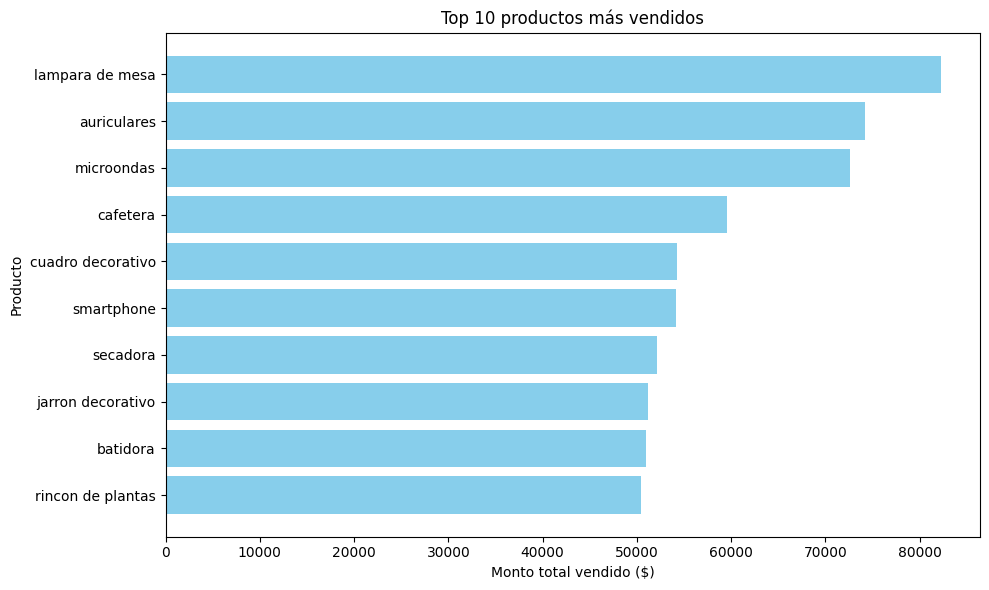

In [72]:
# Seleccionar los 10 productos más vendidos (por monto)
top_productos = dic_dfs["df_cant_ventas_totales"].sort_values('precio_total', ascending= False).head(10)

plt.figure(figsize=(10,6))
plt.barh(top_productos['producto'], top_productos['precio_total'], color='skyblue')
plt.title('Top 10 productos más vendidos')
plt.xlabel('Monto total vendido ($)')
plt.ylabel('Producto')
plt.gca().invert_yaxis()  # El más alto arriba
plt.tight_layout()
plt.show()

In [73]:
nombres_nuevos = {
                "ventas_precio_total.csv":dic_dfs["df_cant_ventas_totales"],
                "ventas_marketing.csv":dic_dfs["df_ventas_marketing"],
                "ventas_por_canal.csv":dic_dfs["df_ventas_por_canal"],
                "ventas_categoria_canal.csv":dic_dfs["df_ventas_categoria_canal"],
                "ventas_y_cant_totales.csv":dic_dfs["df_cant_ventas_totales"]
                 }

for nombre_nuevo,df_actual in nombres_nuevos.items():
    print(f'nombre_nuevo = {nombre_nuevo}')
    ruta_guardado = carpeta_limpios / nombre_nuevo
    guardar_csv(df_actual, ruta_guardado)
    print(f'Guardado cleaned en: {ruta_guardado}')

nombre_nuevo = ventas_precio_total.csv
Guardado cleaned en: datasets_salida\limpios\ventas_precio_total.csv
nombre_nuevo = ventas_marketing.csv
Guardado cleaned en: datasets_salida\limpios\ventas_marketing.csv
nombre_nuevo = ventas_por_canal.csv
Guardado cleaned en: datasets_salida\limpios\ventas_por_canal.csv
nombre_nuevo = ventas_categoria_canal.csv
Guardado cleaned en: datasets_salida\limpios\ventas_categoria_canal.csv
nombre_nuevo = ventas_y_cant_totales.csv
Guardado cleaned en: datasets_salida\limpios\ventas_y_cant_totales.csv


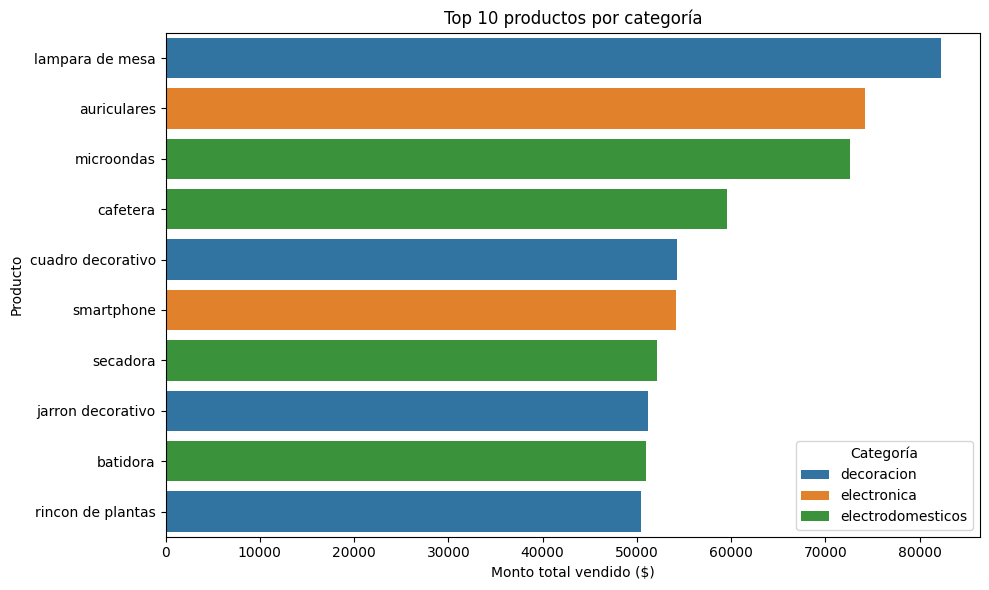

In [75]:
plt.figure(figsize=(10,6))
sns.barplot(data=top_productos, x='precio_total', y='producto', hue='categoria')
plt.title('Top 10 productos por categoría')
plt.xlabel('Monto total vendido ($)')
plt.ylabel('Producto')
plt.legend(title='Categoría')
plt.tight_layout()
plt.show()

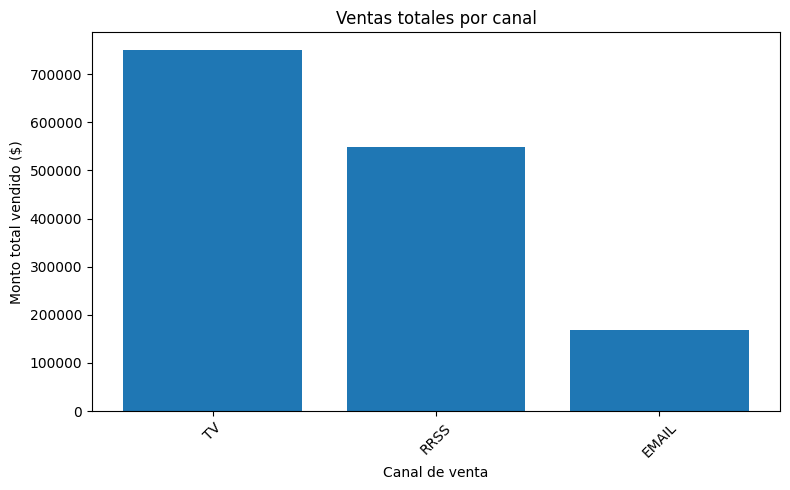

In [76]:
plt.figure(figsize=(8,5))
plt.bar(ventas_por_canal['canal'], ventas_por_canal['total_monto'])
plt.title('Ventas totales por canal')
plt.xlabel('Canal de venta')
plt.ylabel('Monto total vendido ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [98]:
print (f"""Elimino dia de fecha para que quede YYYY/MM
{dic_dfs["df_ventas"].columns}
""")

dic_dfs["df_ventas"]['mes'] = dic_dfs["df_ventas"]['fecha_venta'].dt.to_period('M').astype(str)
ventas_mensuales = (
    dic_dfs["df_ventas"].groupby('mes', dropna=False)
         .agg(
             cantidad_total=('cantidad', 'sum'),
             precio_total=('precio_total', 'sum')
         )
         .reset_index()
         .sort_values('mes')
)

print(f"""{Fore.WHITE+Back.BLUE}\n
╔═════════════════════════════════════════════════════════════════════════════╗
║                             REPORTE VENTAS MENSUALES                        ║
╠═════════════════════════════════════════════════════════════════════════════╣""")
for idx, fila in ventas_mensuales.iterrows():
    print(f"""║ {f"Mes: {fila['mes']},   Cantidad total: {fila['cantidad_total']},   Monto total: {fila['precio_total']}".ljust(75)} ║""")
print (f"""╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")

Elimino dia de fecha para que quede YYYY/MM
Index(['id_venta', 'producto', 'precio', 'cantidad', 'fecha_venta',
       'categoria', 'precio_total', 'mes'],
      dtype='object')



╔═════════════════════════════════════════════════════════════════════════════╗
║                             REPORTE VENTAS MENSUALES                        ║
╠═════════════════════════════════════════════════════════════════════════════╣
║ Mes: 2024-01,   Cantidad total: 1741.0,   Monto total: 129604.9921875       ║
║ Mes: 2024-02,   Cantidad total: 1607.0,   Monto total: 118672.4375          ║
║ Mes: 2024-03,   Cantidad total: 1792.0,   Monto total: 136779.15625         ║
║ Mes: 2024-04,   Cantidad total: 1715.0,   Monto total: 128430.6875          ║
║ Mes: 2024-05,   Cantidad total: 1812.0,   Monto total: 143727.25            ║
║ Mes: 2024-06,   Cantidad total: 1426.0,   Monto total: 108480.171875        ║
║ Mes: 2024-07,   Cantidad total: 1547.0,   Monto total: 116229.96875         ║
║ Mes: 2024-08,   C

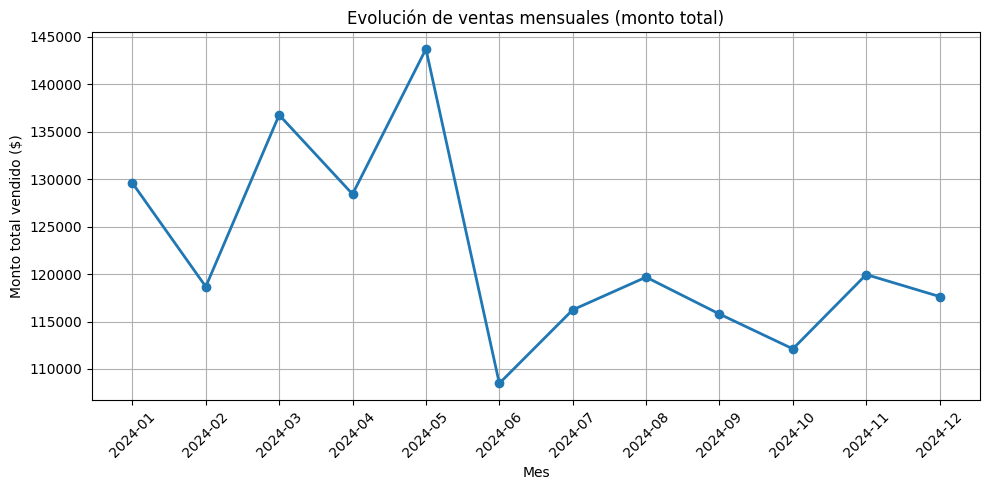

In [85]:
# --- Gráfico 1: monto total por mes ---
plt.figure(figsize=(10,5))
plt.plot(ventas_mensuales['mes'], ventas_mensuales['precio_total'], marker='o', linewidth=2)
plt.title('Evolución de ventas mensuales (monto total)')
plt.xlabel('Mes')
plt.ylabel('Monto total vendido ($)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


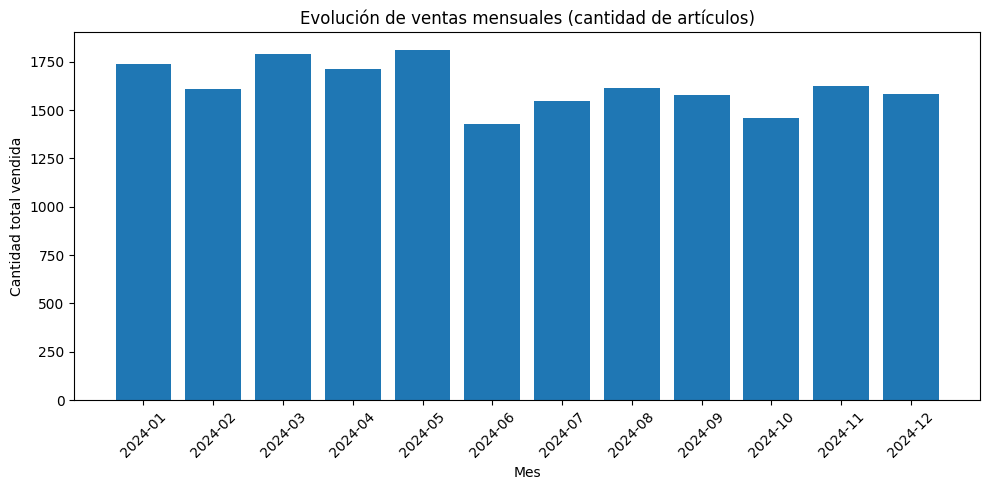

In [86]:

# --- Gráfico 2: cantidad total por mes ---
plt.figure(figsize=(10,5))
plt.bar(ventas_mensuales['mes'], ventas_mensuales['cantidad_total'])
plt.title('Evolución de ventas mensuales (cantidad de artículos)')
plt.xlabel('Mes')
plt.ylabel('Cantidad total vendida')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

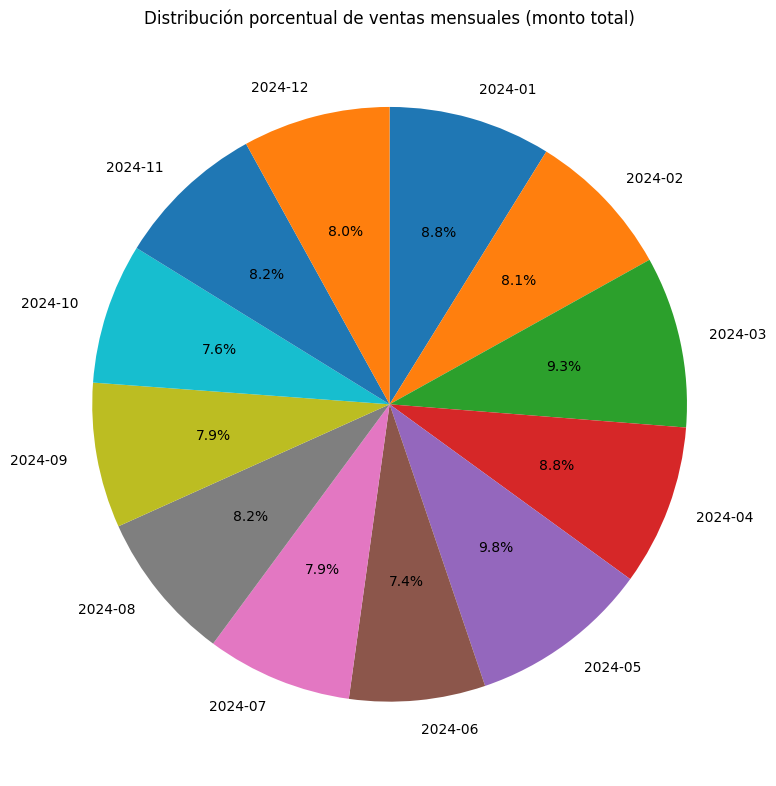

In [87]:
# --- Gráfico de torta ---
plt.figure(figsize=(8, 8))
plt.pie(
    ventas_mensuales['precio_total'],
    labels=ventas_mensuales['mes'],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)

plt.title('Distribución porcentual de ventas mensuales (monto total)')
plt.tight_layout()
plt.show()

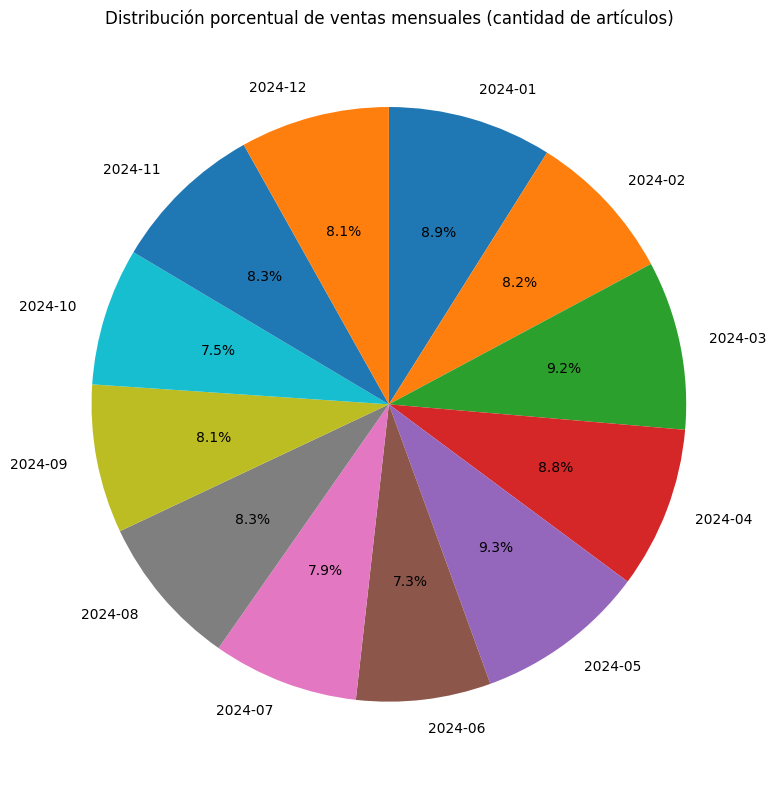

In [88]:
plt.figure(figsize=(8, 8))
plt.pie(
    ventas_mensuales['cantidad_total'],
    labels=ventas_mensuales['mes'],
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)
plt.title('Distribución porcentual de ventas mensuales (cantidad de artículos)')
plt.tight_layout()
plt.show()

In [89]:
percentil_80 = dic_dfs["df_ventas"]["precio_total"].quantile(0.80)
print(f"El percentil 80 del valor total es: {percentil_80:,.2f}")
print(f"""{Fore.WHITE+Back.BLUE}\n
╔═════════════════════════════════════════════════════════════════════════════╗
║                             REPORTE VENTAS MENSUALES                        ║
║               10 primeras ventas de alto rendimiento encontradas                 ║
╠═════════════════════════════════════════════════════════════════════════════╣""")
for idx, fila in ventas_mensuales.iterrows():
    print(f"""║ {f"Mes: {fila['mes']},   Cantidad total: {fila['cantidad_total']},   Monto total: {fila['precio_total']}".ljust(75)} ║""")
print (f"""╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")

El percentil 80 del valor total es: 787.34


In [105]:
for idx, fila in ventas_mensuales.iterrows():
    print(f"Mes: {fila['mes']}, Cantidad total: {fila['cantidad_total']}, Monto total: {fila['precio_total']}")
print(f"""{Fore.WHITE+Back.BLUE}\n
╔═════════════════════════════════════════════════════════════════════════════╗
║                             REPORTE VENTAS MENSUALES                        ║
║               10 primeras ventas de alto rendimiento encontradas                 ║
╠═════════════════════════════════════════════════════════════════════════════╣""")
for idx, fila in ventas_mensuales.iterrows():
    print(f"""║ {f"Mes: {fila['mes']},   Cantidad total: {fila['cantidad_total']},   Monto total: {fila['precio_total']}".ljust(75)} ║""")
print (f"""╚═════════════════════════════════════════════════════════════════════════════╝{Style.RESET_ALL}""")

KeyError: 'monto_total'